<a href="https://colab.research.google.com/github/naveennaren123/Qiskit-two-qubit-tensor-product/blob/main/Gender_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, re, pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

# Load dataset
df = pd.read_csv("NationalNames.csv")[["Name", "Gender"]]

# Clean names
df["Name"] = df["Name"].astype(str).apply(lambda n: re.sub(r"[^a-z]", "", n.lower()))
le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])  # Female=0, Male=1

# Tokenize names at character level
tok = Tokenizer(char_level=True)
tok.fit_on_texts(df["Name"])
X = pad_sequences(tok.texts_to_sequences(df["Name"]), maxlen=15)
y = df["Gender"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential([
    Embedding(input_dim=len(tok.word_index)+1, output_dim=32),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1)

# ✅ Save model (modern .keras format)
model.save("gender_model.keras")

# ✅ Save tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tok, f)


Epoch 1/3
10269/10269 ━━━━━━━━━━━━━━━━━━━━ 68s 6ms/step - accuracy: 0.7862 - loss: 0.4545 - val_accuracy: 0.8350 - val_loss: 0.3741
Epoch 2/3
10269/10269 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.8356 - loss: 0.3743 - val_accuracy: 0.8562 - val_loss: 0.3329
Epoch 3/3
10269/10269 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.8531 - loss: 0.3394 - val_accuracy: 0.8658 - val_loss: 0.3082


In [ ]:
%%writefile app.py
import streamlit as st, re, pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load model and tokenizer
model = load_model("gender_model.keras")
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

def clean(name):
    return re.sub(r"[^a-z]", "", name.lower())

def predict(name):
    seq = pad_sequences(tokenizer.texts_to_sequences([clean(name)]), maxlen=15)
    p = model.predict(seq)[0][0]
    return "Male" if p > 0.5 else "Female"

st.title("👤 Gender Prediction from Name")
st.markdown("This app uses an LSTM model trained on a large baby names dataset to predict gender from a given name.")
n = st.text_input("Enter a Name:")
if st.button("Predict"):
    if not n.strip():
        st.warning("Please enter a name.")
    else:
        st.success(f"Predicted Gender: **{predict(n)}**")


Overwriting app.py


In [ ]:
from pyngrok import ngrok
ngrok.kill()
ngrok.set_auth_token("35TKC4YBBYuthRJdDfetAjCZu2w_5LMwmXx6HK1aWiyimf7Us")  # paste your token here

# Start tunnel and Streamlit app
public_url = ngrok.connect(8501, "http")
print("🌐 Streamlit App URL:", public_url)
!streamlit run app.py --server.port 8501 &


🌐 Streamlit App URL: NgrokTunnel: "https://avian-marvella-totalitarian.ngrok-free.dev" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.11.181.175:8501

2025-11-14 14:40:34.173746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763131234.195119   16256 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763131234.201689   16256 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763131234.217816   16256 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the 

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict probabilities
y_pred_probs = model.predict(X_test)

# Convert to 0/1
y_pred = (y_pred_probs > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=["Female", "Male"]))


11409/11409 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
Accuracy: 0.8641748405174657

Classification Report:

              precision    recall  f1-score   support

      Female       0.89      0.88      0.88    216091
        Male       0.83      0.84      0.83    148996

    accuracy                           0.86    365087
   macro avg       0.86      0.86      0.86    365087
weighted avg       0.86      0.86      0.86    365087



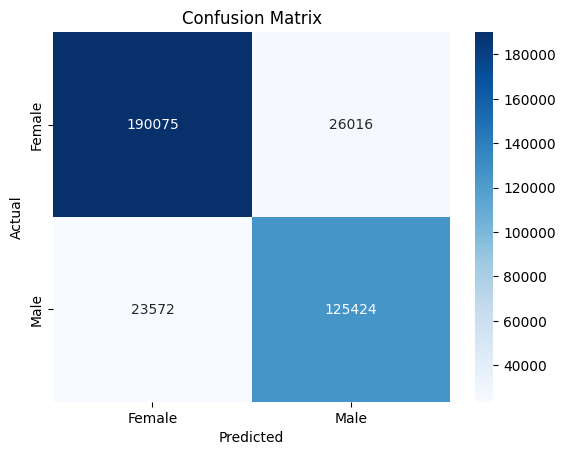

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Female", "Male"],
            yticklabels=["Female", "Male"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
